# Plant Pathology Dataset Keras

### Train & Validation, Test Splitting 

This section has been run previously. The output dataset can be found in the input folder.

```python

src_dir = "../input/plantvillage/images" #r"../plant-pathology-2020-fgvc7/images"
train_val_dst_dir = "../working/train&val_images" #r"../plant-pathology-2020-fgvc7/train&val_images" #"../working/train&val_images"
test_dst_dir = "../working/test_images" #r"../plant-pathology-2020-fgvc7/test_images"  #"../working/test_images"

if not os.path.isdir(train_val_dst_dir):
    os.mkdir(train_val_dst_dir)
if not os.path.isdir(test_dst_dir):
    os.mkdir(test_dst_dir)


if len([f for f in os.listdir(test_dst_dir)]) == 0:
    all_images_names = os.listdir(src_dir)
    train_val_images = []
    test_images  = []
    for image in all_images_names:
        if "Train" in image:
            shutil.copy(src_dir+"/"+image,train_val_dst_dir)
        elif "Test" in image:
            shutil.copy(src_dir+"/"+image,test_dst_dir)
        else:
            print("error")

# Check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_val_total = len([f for f in  os.listdir(train_val_dst_dir)])
test_total = len([f for f in  os.listdir(test_dst_dir)])
print(total == train_val_total + test_total)
```
[ ] : True

### Modules

In [1]:
# INSTALL
# Latest version of tensorflow, which comes with useful image loading APIs
!pip install tf-nightly  # run only once per session

# IMPORT

## Magic commands for interactivity
%pylab inline                 

## Basic Utilities  
import sys                    # Enabler of operating system dependent functionality
import os                     # Provides access to some variables & functions for the interpreter
import shutil                 # Provides high-level operations on files and collections of files
from shutil import copyfile   # Import module we'll need to import our custom module
import math                   # Provides access to basic mathematical functions
import time                   # Provides various time-related functions
import glob                   # Pathnames management
from PIL import Image as pil_image
import itertools

## Data Manipulation & Analysis
import pandas as pd           # Methods to manipulate, filter, group, and transform data
import numpy as np            # Efficient storage and computation for multi-dimensional data arrays
from numpy import expand_dims

## Data Visualization 
import matplotlib             # Interface for creation of publication-quality plots and figures
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import seaborn as sns         # Matplotlib-based statistical data visualization interface 
### import plotly             # Interactive plotting library 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

## Machine Learning 
### Scikit-Learn
from sklearn.model_selection import train_test_split # Split arrays or matrices into random train and test subsets
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
### TensorFlow
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, save_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow.keras.layers as L
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import Adam , RMSprop
### SMOTE
from imblearn.over_sampling import SMOTE # Class Balancing 

     |████████████████████████████████| 322.3 MB 14 kB/s 
     |████████████████████████████████| 3.0 MB 44.4 MB/s 
     |████████████████████████████████| 459 kB 16.0 MB/s 
Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Data Exploration

In [2]:
# Here we get an insight of the datasets

kaggle = True
if kaggle:
    outdir = r"../working/"
    indir = r"../input/plantvillage/"
else:
    outdir = r"Q:/tooBigToDrive/plantsvillage/temp/"
    indir = r"Q:/tooBigToDrive/plantsvillage/"
    
test_dir = indir + "plantvillage_split_dataset/test_images"
train_labels_csv = pd.read_csv(indir+"plantvillage_split_dataset/train.csv")
print(train_labels_csv.head())
print("-------------------------------------")
example_submission_csv = pd.read_csv(indir+"plantvillage_split_dataset/sample_submission.csv")
print(example_submission_csv.head() )
print("-------------------------------------")
test_csv = pd.read_csv(indir+"plantvillage_split_dataset/test.csv")
test_paths_csv= pd.DataFrame(test_csv["image_id"].apply(lambda x: test_dir+"/"+x+".jpg"))
print(test_paths_csv.head() )

  image_id  healthy  multiple_diseases  rust  scab
0  Train_0        0                  0     0     1
1  Train_1        0                  1     0     0
2  Train_2        1                  0     0     0
3  Train_3        0                  0     1     0
4  Train_4        1                  0     0     0
-------------------------------------
  image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25
-------------------------------------
                                            image_id
0  ../input/plantvillage/plantvillage_split_datas...
1  ../input/plantvillage/plantvillage_split_datas...
2  ../input/plantvillage/plantvillage_split_datas...
3  ../input/plantvillage/plantvillage_split_datas...
4  ../input/plantvillage/plantvillage_split_dat

### Train, Validation Splitting

The following cell creates four directories `healthy`, `multiple_diseases`, `rust`, `scab` with the corresponding images from the train dataset. It is a very technical part due to the way the images need to be organized for TensorFlow.

In [3]:
# Create csv files with images
train_val_healthy_csv = train_labels_csv[train_labels_csv["healthy"] == 1]
train_val_multiple_diseases_csv  = train_labels_csv[train_labels_csv["multiple_diseases"] == 1]
train_val_rust_csv = train_labels_csv[train_labels_csv["rust"] == 1]
train_val_scab_csv = train_labels_csv[train_labels_csv["scab"] == 1]

# We will check that this has no entry
two_classes = train_labels_csv[(train_labels_csv["scab"] == 1) & (train_labels_csv["multiple_diseases"] == 1)]

train_val_healthy_names = train_val_healthy_csv["image_id"].tolist()
train_val_multiple_diseases_names = train_val_multiple_diseases_csv["image_id"].tolist()
train_val_rust_names = train_val_rust_csv["image_id"].tolist()
train_val_scab_names = train_val_scab_csv["image_id"].tolist()

src_dir = indir+"plantvillage_split_dataset/train&val_images" #"../input/plantvillage/images"
train_dst_dir = outdir+"train" #"../working/train&val_images"

# val_dst_dir = outdir+"val"  #"../working/test_images"
train_dst_healthy_dir = outdir+"train/healthy"#"../working/train&val_images"
train_dst_multiple_diseases_dir =outdir+"train/multiple_diseases"
train_dst_rust_dir = outdir+"train/rust"
train_dst_scab_dir = outdir+"train/scab"

test_dst_dir = outdir + "test_image/test"

# Create and fill the directories
try:
    os.mkdir(train_dst_dir)

    os.mkdir(train_dst_healthy_dir)
    os.mkdir(train_dst_multiple_diseases_dir)
    os.mkdir(train_dst_rust_dir)
    os.mkdir(train_dst_scab_dir)
    os.makedirs(test_dst_dir)

    for image in train_val_healthy_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_healthy_dir)
            
    for image in train_val_multiple_diseases_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_multiple_diseases_dir)

    for image in train_val_rust_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_rust_dir)

    for image in train_val_scab_names :
            shutil.copy(src_dir+"/"+image+".jpg",train_dst_scab_dir)

    for image in test_paths_csv["image_id"].tolist():
        shutil.copy(image,test_dst_dir)
        
except FileExistsError as err:
    print("folders already exist")
 
# Check for possible errors
total = len([f for f in  os.listdir(src_dir)])
train_healthy_total = len([f for f in  os.listdir(train_dst_healthy_dir)])
train_multiple_diseases_total = len([f for f in  os.listdir(train_dst_multiple_diseases_dir)])
train_rust_total = len([f for f in  os.listdir(train_dst_rust_dir)])
train_scab_total = len([f for f in  os.listdir(train_dst_scab_dir)])

total = train_healthy_total + train_multiple_diseases_total +train_rust_total+ train_scab_total 
train_size = math.ceil(total*0.8)
val_size = total - train_size
test_size = test_csv.size 
image_size  = (200,200)
batch_size = 32
seed = 100
print(train_healthy_total,train_multiple_diseases_total,train_rust_total,train_scab_total,)

516 91 622 592


### Class Balancing & Data Augmentation/Prepocessing

The function `create_augmented_data` performs class balancing with `SMOTE` and data augmentation with `ImageDataGenerator` by TensorFlow.

We have tried multiple variants of `SMOTE` and `ImageDataGenerator` and selected the following configuration as optimal taking the performance into account. <br> Please notice that the function is split in two by the `valid` parameter: it allows to apply the function to output both the train and validation data together and just the train . 

In [4]:
def create_augmented_data(train_dst_dir , train_generator, val_generator, aug, batch_size, valid = True):
    if valid:
        # Load data into tensorflow dataset: if we used the flow_form_directory method of the train_generator, 
        ## it would have been  too slow
        print("loading data...")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dst_dir,
        validation_split=0.2,
        subset="training",
        seed=1337,
        image_size=image_size,
        batch_size=train_size, 
        )

        val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            train_dst_dir,
            validation_split=0.2,
            subset="validation",
            seed=1337,
            image_size=image_size,
            batch_size=val_size,
        )
        
        print("augmenting train...")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        print("x done")
        y_train = np.array(res[1])
        yforpca = y_train
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        xforpca = x_train
        print("flattened")

        smote_train = SMOTE(sampling_strategy = "all", random_state = 420,k_neighbors=10,n_jobs=4) # svmsmote goes out of memory in all configs
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        tot_train = len(x_train)
        print("total_train after smote = ", x_train.shape)
        yforpca1 = y_train #
        xforpca1 = x_train  #
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution after smote = ", counts)
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )
        
        
        train_generator.fit(x_train, seed = seed)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train,seed = seed).next() 
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)
        
        # Save memory
        del x_train
        #del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels

        print("train augmented, augmenting val...")
        #i = 0
        res = list(zip(*val_ds.unbatch().as_numpy_iterator()))
        x_val = np.array(res[0])
        y_val = np.array(res[1])
        y_val_cat = tf.keras.utils.to_categorical(
            y_val, num_classes=4, dtype='float32'
        )
        print(x_val.shape,y_val.shape,y_val_cat.shape)
        
        
        val_generator.fit(x_val)
        aug_val_images, aug_val_labels = val_generator.flow(x = x_val,y = y_val_cat,shuffle = False,batch_size = val_size,seed = seed).next()
        aug_val_images = np.array(aug_val_images)
        aug_val_labels = np.array(aug_val_labels)

        del x_val
        del val_ds

        out_val_datagen = ImageDataGenerator()
        out_val_datagen.fit(aug_val_images)
        out_val_flow = out_val_datagen.flow(aug_val_images,aug_val_labels,batch_size = val_size, shuffle = False)

        del aug_val_images
        del aug_val_labels
        del res

        print("returning")
        return (out_train_flow,out_val_flow,y_val,y_train,tot_train)
    # If validation is not provided / one intends to test
    else:
        print("loading data...")
        train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dst_dir,
        seed=1337,
        image_size=image_size,
        batch_size=train_size, 
        )
        
        print("augmenting train...")
        res = list(zip(*train_ds.unbatch().as_numpy_iterator()))
        x_train = np.array(res[0])
        y_train = np.array(res[1])
        print(x_train.shape,y_train.shape)
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution before smote = ", counts)
        x_train  = np.array([image.flatten() for image in x_train ])
        print("flattened")
        yforpca = y_train 
        xforpca = x_train  
        smote_train = SMOTE(sampling_strategy = "all", random_state = 420,k_neighbors=10,n_jobs=4)
        x_train, y_train = smote_train.fit_resample(x_train, y_train)
        x_train = np.reshape(x_train,(-1,200,200,3))
        yforpca1 = y_train 
        xforpca1 = x_train 
        unique, counts = numpy.unique(y_train, return_counts=True)
        print("class distribution after smote = ", counts)
        tot_train = len(x_train)
        print("total_train after smote = ", x_train.shape)
        
        y_train_cat = tf.keras.utils.to_categorical(
            y_train, num_classes=4, dtype='float32'
        )   

        train_generator.fit(x_train,seed = seed)
        aug_train_images, aug_train_labels = train_generator.flow(x = x_train,y = y_train_cat,shuffle = False,batch_size = tot_train,seed = seed).next()
        aug_train_images = np.array(aug_train_images)
        aug_train_labels = np.array(aug_train_labels)

        del x_train
        del y_train
        del train_ds

        out_train_datagen = ImageDataGenerator()
        out_train_datagen.fit(aug_train_images)
        out_train_flow = out_train_datagen.flow(aug_train_images,aug_train_labels,batch_size = batch_size,shuffle = False)

        del aug_train_images
        del aug_train_labels
        
        return (out_train_flow,tot_train,xforpca,yforpca,xforpca1,yforpca1)

### Test Set Preprocessing

The test set is preprocessed just as the validation set, in order to give the model the same feature distribution.

In [5]:
def get_augmented_test(test_dir, test_generator):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        outdir + "test_image",
        labels="inferred",
        label_mode="int",
        class_names=None,
        color_mode="rgb",
        batch_size=test_size,
        image_size=image_size,
        shuffle = False,
        seed=None,
        validation_split=None,
        subset=None,
        interpolation="bilinear",
        follow_links=False,
    )
    
    x_test = np.array([ array for array, label in test_ds.unbatch().as_numpy_iterator()])
    test_generator.fit(x_test,seed = seed)
    test_flow = test_generator.flow(
        x= x_test,
        y=None,
        batch_size = test_size,
        shuffle=False,seed = seed)

    test_imgs = test_flow.next()

    del test_ds
    del x_test
    del test_generator

    return test_imgs

### Data Generators 


In [6]:
# TRAIN
train_datagen = ImageDataGenerator(rotation_range=360,                # DATA AUGMENTATION
                                   #shear_range=.25,                  # DATA AUGMENTATION
                                   #zoom_range=.25,                   # DATA AUGMENTATION
                                   #width_shift_range=.25,            # DATA AUGMENTATION
                                   #height_shift_range=.25,           # DATA AUGMENTATION
                                   rescale=1./255,                    # DATA MODIFICATION
                                   #brightness_range=[.5,1.5],        # DATA AUGMENTATION
                                   horizontal_flip=True,              # DATA AUGMENTATION
                                   #vertical_flip=True                # DATA AUGMENTATION
                                  )

# VALIDATION
val_datagen = ImageDataGenerator(rescale=1./255)

# TEST
test_datagen = ImageDataGenerator(rescale=1./255)

# To train and validate
train_flow_80, val_flow, y_val, y_train,total_train_80 = create_augmented_data(train_dst_dir  = train_dst_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = batch_size )
train_flow,total_train,x,y,xS,yS = create_augmented_data(train_dst_dir  = train_dst_dir,train_generator = train_datagen, val_generator = val_datagen , aug = 5, batch_size = 32, valid = False )

loading data...
Found 1821 files belonging to 4 classes.
Using 1457 files for training.
Found 1821 files belonging to 4 classes.
Using 364 files for validation.
augmenting train...
x done
(1457, 200, 200, 3) (1457,)
class distribution before smote =  [407  74 501 475]
flattened
total_train after smote =  (2004, 200, 200, 3)
class distribution after smote =  [501 501 501 501]
train augmented, augmenting val...
(364, 200, 200, 3) (364,) (364, 4)
returning
loading data...
Found 1821 files belonging to 4 classes.
augmenting train...
(1821, 200, 200, 3) (1821,)
class distribution before smote =  [516  91 622 592]
flattened
class distribution after smote =  [622 622 622 622]
total_train after smote =  (2488, 200, 200, 3)


### Keras Implementation

#### Callbacks 

Here we instantiate a **checkpoint callback**: a learning rate modifier which saves the best model weights both for prediction and for stocasticity evaluation.

In [10]:
# Create a directory to save outputs 
os.makedirs("../working/Saved/")

args = {
    "save_weights_only":True,
    "monitor":'val_categorical_auc',
    "mode":'max',
    "save_best_only":True,
    "verbose":0  }

checkpoint_filepaths = ["../working/Saved/drop0.hdf5","../working/Saved/drop1.hdf5","../working/Saved/drop2.hdf5","../working/Saved/drop3.hdf5","../working/Saved/drop4.hdf5"
                       ,"../working/Saved/drop5.hdf5","../working/Saved/drop6.hdf5","../working/Saved/drop7.hdf5","../working/Saved/drop8.hdf5","../working/Saved/drop9.hdf5"]

### Models

#### Pre-Trained Keras Model: **DenseNet121**

In [11]:
def get_deeper_model():
    #reg = .0005
    
    METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.AUC(name='categorical_auc',multi_label=True),
        ]
    
    model = tf.keras.Sequential([DenseNet121(input_shape=(200, 200, 3),
                                weights='imagenet',
                                include_top=False),
                                L.GlobalAveragePooling2D(),
                                L.Dense(4,activation='softmax')])
        
    model.compile(optimizer='adam',
                loss = 'categorical_crossentropy',
                metrics=METRICS)
    
    print(model.summary())
    return model

#### Explicit Keras Model: **EKM**

In [12]:
def get_model(drop):
    
    METRICS = [ 
      tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
      tf.keras.metrics.AUC(name='categorical_auc',multi_label=True),
        ]
    
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 200x 200 with 3 bytes color

        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)), #, input_shape=(150, 150, 3)
        tf.keras.layers.MaxPooling2D(2, 2),

        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(drop),
        tf.keras.layers.Dense(4, activation='softmax')
    ])


    model.compile(RMSprop(lr=5e-4,momentum = 0.1),loss='categorical_crossentropy', metrics = METRICS)

    # Model Summary
    #print(model.summary())
    
    return model

### Model Training & Validation (80%, 20%)

The EKM is trained on 80% of train data and validated on the rest.

In [13]:
drops =[0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
val_loss =[]
max_val_loss_epoch = []
val_acc = []
max_val_acc_epoch = []
val_auc = []
max_val_auc_epoch = []
histories = []
epochs_l = []
i = 0
for drop in drops:
    model = get_model(drop)
    args["filepath"] = checkpoint_filepaths[i]
    history = model.fit_generator(train_flow_80,
                steps_per_epoch = total_train_80 // batch_size, #train_size//batch_size
                epochs=80, # the model never seems to suffer from validation loss increase (even up to 100 epochs)
                validation_data=val_flow,
                validation_steps=1,
                callbacks = [ModelCheckpoint(**args)],                  # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
                workers=4,
                verbose = 0 )   
    val_loss.append(np.max(np.array(history.history["val_loss"])))
    val_acc.append(np.max(np.array(history.history['val_categorical_accuracy'])))
    val_auc.append(np.max(np.array(history.history['val_categorical_auc'])))
    epochs_l.append(np.argmax(np.array(history.history['val_categorical_auc'])))
    histories.append(history)
    i = i+1
    print("drop  = ",drop, "done, next...")
    
history  = histories[np.argmax(np.array(val_auc))]
drop = drops[np.argmax(np.array(val_auc))]
epochs = epochs_l[np.argmax(np.array(val_auc))]+1 #epochs = np.argmax(np.array(history.history["val_categorical_auc"]))
best_weights = checkpoint_filepaths[np.argmax(np.array(val_auc))]

drop  =  0.0 done, next...
drop  =  0.1 done, next...
drop  =  0.2 done, next...
drop  =  0.3 done, next...
drop  =  0.4 done, next...
drop  =  0.5 done, next...
drop  =  0.6 done, next...
drop  =  0.7 done, next...
drop  =  0.8 done, next...
drop  =  0.9 done, next...


best drop =  0.9 best epochs =  65 best_weights =  ../working/Saved/drop9.hdf5


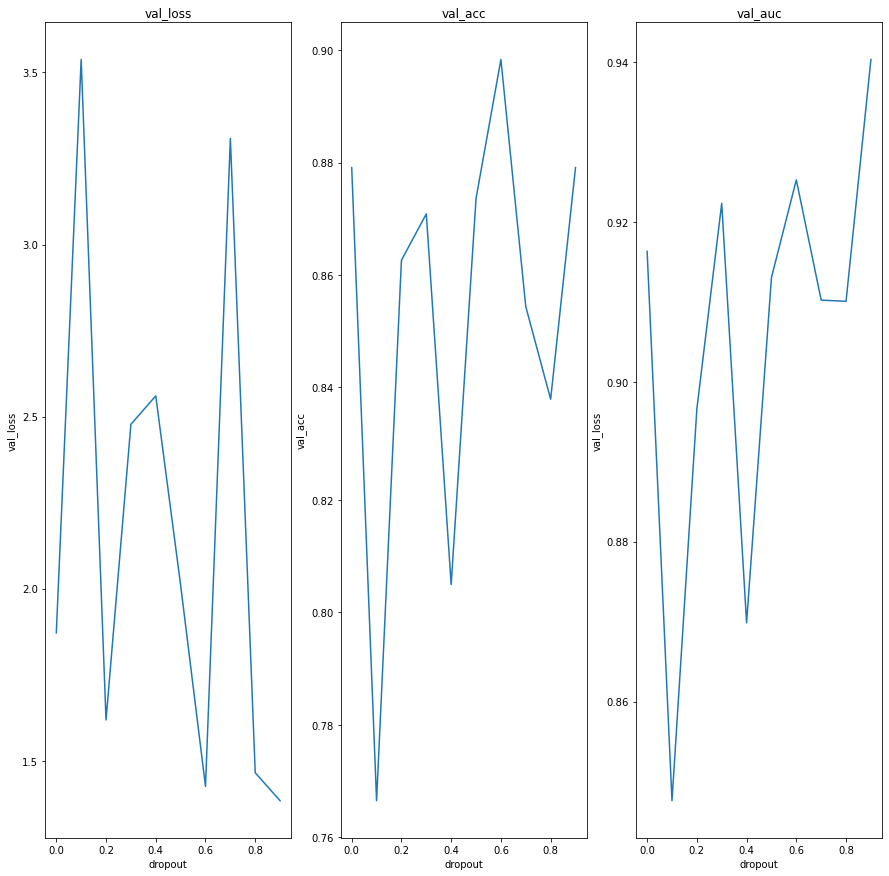

In [14]:
print("best drop = ", drop,"best epochs = ", epochs, "best_weights = ", best_weights)

fig, axs = plt.subplots(1,3, figsize = (15,15))
axs[0].set_title("val_loss")
axs[0].set_xlabel("dropout")
axs[0].set_ylabel("val_loss")
axs[0].plot(drops, val_loss)

axs[1].set_title("val_acc")
axs[1].set_xlabel("dropout")
axs[1].set_ylabel("val_acc")
axs[1].plot(drops, val_acc)

axs[2].set_title("val_auc")
axs[2].set_xlabel("dropout")
axs[2].set_ylabel("val_loss")
axs[2].plot(drops, val_auc) 

In [15]:
model_new = get_model(drop)
history_new = model_new.fit_generator(train_flow_80,
            steps_per_epoch = total_train_80 // batch_size, #train_size//batch_size
            epochs=80,           # the model never seems to suffer from validation loss increase (even up to 100 epochs)
            validation_data=val_flow,
            validation_steps=1,  # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
            workers=4)   

deeper_model = get_deeper_model()
deeper_history = deeper_model.fit_generator(train_flow_80,
            steps_per_epoch = total_train_80 // batch_size, #train_size//batch_size
            epochs=20,               # the model never seems to suffer from validation loss increase (even up to 100 epochs)
            validation_data=val_flow,
            validation_steps=1,      # we tried early stopping and learning rate scheduling, but they proved inefficient due to the high loss swipes we had during training.
            workers=4)

Epoch 1/80
62/62 [==============================] - 3s 44ms/step - loss: 1.3962 - categorical_accuracy: 0.2444 - categorical_auc: 0.5033 - val_loss: 1.3750 - val_categorical_accuracy: 0.3324 - val_categorical_auc: 0.5170
Epoch 2/80
62/62 [==============================] - 2s 34ms/step - loss: 1.3936 - categorical_accuracy: 0.2429 - categorical_auc: 0.5015 - val_loss: 1.3783 - val_categorical_accuracy: 0.4176 - val_categorical_auc: 0.5171
Epoch 3/80
62/62 [==============================] - 2s 36ms/step - loss: 1.3873 - categorical_accuracy: 0.2606 - categorical_auc: 0.5158 - val_loss: 1.3624 - val_categorical_accuracy: 0.3352 - val_categorical_auc: 0.5522
Epoch 4/80
62/62 [==============================] - 2s 35ms/step - loss: 1.3815 - categorical_accuracy: 0.2606 - categorical_auc: 0.5512 - val_loss: 1.3482 - val_categorical_accuracy: 0.4396 - val_categorical_auc: 0.6111
Epoch 5/80
62/62 [==============================] - 2s 35ms/step - loss: 1.3714 - categorical_accuracy: 0.3114 - cat

### Training Histories 

In [16]:
def plot_train_history(history):
    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['categorical_accuracy'], marker=dict(color="dodgerblue"),
                name="Train acc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['val_categorical_accuracy'], marker=dict(color="darkblue"),
                name="Val acc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['categorical_auc'], marker=dict(color="orange"),
                name="Train auc"))

    fig.add_trace(
        go.Scatter(x=np.arange(1, 100+1), mode='lines+markers', y=history.history['val_categorical_auc'], marker=dict(color="orangered"),
                name="Val auc"))

    fig.update_layout(title_text="", yaxis_title= "Metrics", xaxis_title="Epochs", template="plotly_white")
    fig.show()

#### DenseNet121

In [19]:
plot_train_history(deeper_history)

### Confusion Matrix

In [20]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### EKM

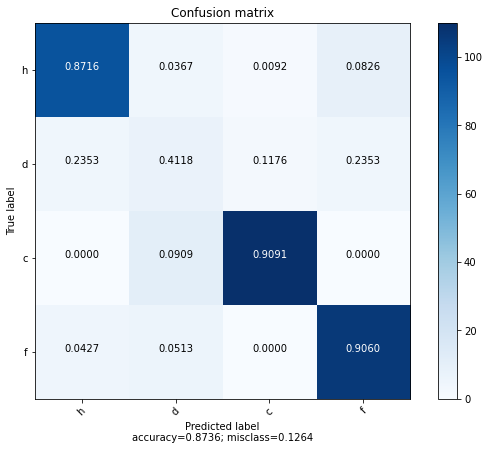

In [21]:
Y_pred = model.predict_generator(val_flow, train_size // batch_size +1) #128 +1
y_pred = np.argmax(Y_pred, axis=1)
a = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(a,["h","d","c","f"],normalize=True)

#### DenseNet121

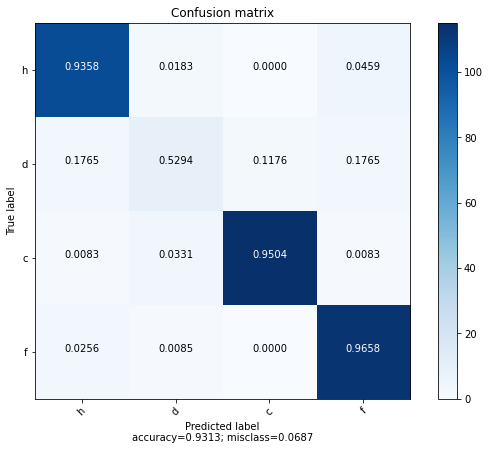

In [22]:
Y_pred = deeper_model.predict_generator(val_flow, train_size // batch_size +1) #128 +1
y_pred = np.argmax(Y_pred, axis=1)
a = confusion_matrix(y_val, y_pred)

plot_confusion_matrix(a,["h","d","c","f"],normalize=True)